# ROIScene Class Example

In Pandora we are interested in Regions of Interest around certain stars. While the `Scene` class is useful for modeling Full Frame Images, the `ROIScene` class is useful for modeling cut outs of larger scenes. Regions of interest are special cases.

In [1]:
from pandorapsf import ROIScene, PSF
import matplotlib.pyplot as plt
import numpy as np

In [2]:
p = PSF.from_name("VISDA")

In [3]:
p

2D PSF Model [row, column]

In [4]:
nROIs = 9
ROI_size = (50, 51)
ROI_corners = [(int(r), int(c)) for r, c in np.random.uniform(-800, 800, (2, 9)).T]

We'll need some locations at which to place some PSFs. We can randomly generate some locations. Here I am generating sources across the entire region of the detector.

In [5]:
import numpy as np
nsources = 30
r = np.hstack([np.random.uniform(corner[0] - 20, corner[0] + ROI_size[0] + 20, (nsources)) for corner in ROI_corners])
c = np.hstack([np.random.uniform(corner[1] - 20, corner[1] + ROI_size[1] + 20, (nsources)) for corner in ROI_corners])

Below I show a plot of where the sources fall and the ROIs we've randomly generated.

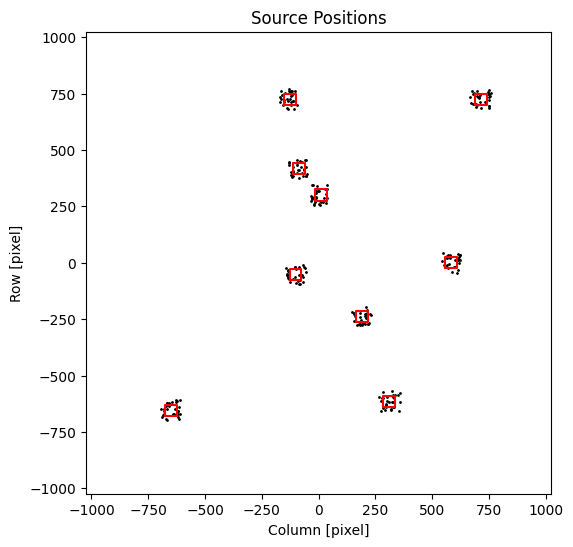

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(c, r, s=1, c='k')
[ax.plot([corner[1], corner[1] + ROI_size[1], corner[1] + ROI_size[1], corner[1], corner[1]], [corner[0], corner[0], corner[0] + ROI_size[0], corner[0] + ROI_size[0], corner[0]], c='r') for corner in ROI_corners] 
ax.set(xlim=(-1024, 1024), ylim=(-1024, 1024), xlabel='Column [pixel]', ylabel='Row [pixel]', title='Source Positions');

<div class="admonition note">
    <p class="admonition-title">Note</p>
    <p>
        I have included sources close to the ROIs with some buffer around them. If we include too many sources this will be slow to calculate. If we do not include a buffer we could miss sources that have flux from PSF wings fall into the ROI. We also need nearby sources that may move into the ROI if there is significant motion. Use your judgement to find a balance between including sources and keeping the number of sources low.
    </p>
</div>

We can now build the scene object

In [7]:
s = ROIScene(locations=np.asarray([r, c]).T,
             psf=p,
             shape=(2048, 2048),
             corner=(-1024, -1024), 
             nROIs=nROIs,
             ROI_size=ROI_size,
             ROI_corners=ROI_corners
            )

We've now created our ROIscene object. We can use the `model` class method to model an image. We'll have to pass in some fluxes to model, we can make those randomly.

In [8]:
flux = 10**np.random.normal(0, 0.4, s.ntargets)

In [9]:
images = s.model(flux**0)

This has modeled an image stack for us. We expect one time (we only passed a single flux value) 9 ROIs, and the ROI image shape..

In [10]:
images.shape

(9, 1, 50, 51)

Here we have the images for each ROI, then each time, as a function of row then column. We could optionally pass in more times, and position changes as we have done in the `Scene` class.

In [11]:
ntimes = 100
flux = 10**np.random.normal(0, 0.4, (s.ntargets))[:, None] * np.ones(ntimes)
delta_position = np.random.uniform(-6, 6, (2, ntimes))

In [12]:
images = s.model(flux, delta_pos=delta_position)

Modeling Pixel Positions: 100%|█████████████████| 72/72 [00:08<00:00,  8.44it/s]


In [13]:
images.shape

(9, 100, 50, 51)

Now we have 100 time samples for 9 ROIs. Let's take a look at the images. We'll look at the first 3 images of the first ROI.

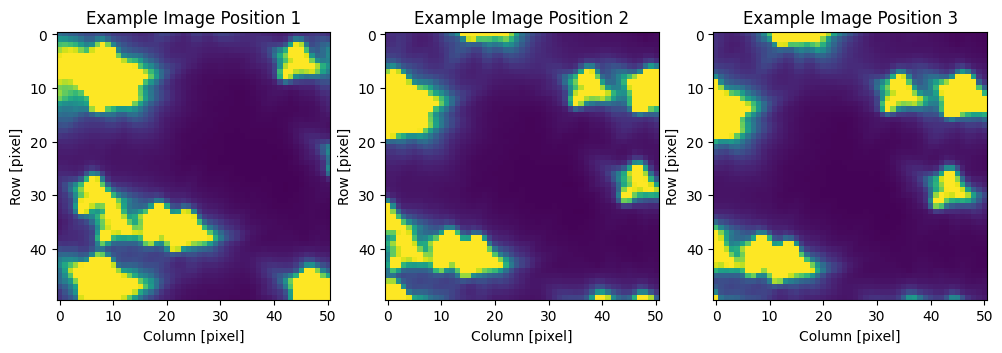

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(images[0, 0], vmin=0, vmax=0.01)
ax[1].imshow(images[0, 1], vmin=0, vmax=0.01)
ax[2].imshow(images[0, 2], vmin=0, vmax=0.01)
ax[0].set(xlabel='Column [pixel]', ylabel='Row [pixel]', title='Example Image Position 1');
ax[1].set(xlabel='Column [pixel]', ylabel='Row [pixel]', title='Example Image Position 2');
ax[2].set(xlabel='Column [pixel]', ylabel='Row [pixel]', title='Example Image Position 3');

You can see the image is the same but shifted, since we've included a delta position parameter. 